# EDA on OBJ file

In this notebook, I attempt to conduct some EDA on an OBJ file. OBJ files are similar to CSV, and contain vertex, edge and face information about a 3D object (as well as certain other properties). Let's load one up and see what we can do with it. 

In [61]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

Before loading the OBJ file to a pandas dataframe, lets briefly explore it's contents.

The OBJ file looks similar to a basic CSV, except our delimiter is a `space`. I see 4 main categories in our first column of data- `v`, `vn`, `vt`, and `f`. These stand for `vertex`, `vertex-normal`, `vertex-texture` and `face` respectively

    `v`: Vertex, the individual data points.
    `vn`: Vertex-Normal, the normal vector to a vertex, used for lighting and refelctions.
    `vt`: Vertex-Texture, contains information about the texture map at the point in the object.
    `f`: Face, collection of 3-4 verticecs, along with information about the normal and texture.

Since our data seems to consist of 4 distinct datasets, it might be best to split these out.

## Loading and Cleaning the Data

Load our OBJ data file.

In [62]:
obj = pd.read_csv("../data/human-foot-in-blender.obj", delimiter=' ', names=['1','2','3','4','5'], skiprows=3, header=None)
obj.head()

,1,2,3,4,5
0,v,0.059608,0.383419,-0.047925,NaN
1,v,-0.030599,-0.016010,-0.020009,NaN
2,v,0.052395,0.402345,0.102574,NaN
3,v,0.049393,-0.015811,-0.022423,NaN
4,v,-0.061567,0.421855,-0.066727,NaN


Here I had to manually choose 5 columns to be read into our dataframe. This corresponds to the faces, which each have 4 data points.

Let's split our data into vertices, vertex-normals, vertex-textures, and faces.

In [63]:
vertices = obj[ obj['1'] == 'v' ]
vertex_textures = obj[ obj['1'] == 'vt' ]
vertex_normals = obj[ obj['1'] == 'vn' ]
faces = obj[ obj['1'] == 'f' ]

Let's take a look at what our data looks like.

In [64]:
vertices.head()

,1,2,3,4,5
0,v,0.059608,0.383419,-0.047925,NaN
1,v,-0.030599,-0.016010,-0.020009,NaN
2,v,0.052395,0.402345,0.102574,NaN
3,v,0.049393,-0.015811,-0.022423,NaN
4,v,-0.061567,0.421855,-0.066727,NaN


In [65]:
vertex_normals.head()

,1,2,3,4,5
800,vn,0.8359,0.0076,-0.5488,NaN
801,vn,-0.0570,-0.9954,0.0770,NaN
802,vn,0.6646,0.1227,0.7370,NaN
803,vn,0.1375,-0.9905,0.0050,NaN
804,vn,-0.7827,0.0011,-0.6224,NaN


In [66]:
vertex_textures.head()

,1,2,3,4,5
1600,vt,0.625000,0.627438,NaN,NaN
1601,vt,0.625000,0.632199,NaN,NaN
1602,vt,0.625000,0.583333,NaN,NaN
1603,vt,0.625000,0.583347,NaN,NaN
1604,vt,0.625000,0.500000,NaN,NaN


In [67]:
faces.head()

,1,2,3,4,5
1723,f,716/1/716,32/2/32,34/3/34,713/4/713
1724,f,87/5/87,17/6/17,18/7/18,84/8/84
1725,f,60/9/60,796/9/796,797/10/797,68/11/68
1726,f,65/12/65,786/12/786,789/13/789,64/14/64
1727,f,84/8/84,18/7/18,13/15/13,89/16/89


Our `vertices` dataframe contains some unnecessary columns. Let's drop those and also rename to X, Y and Z.

In [68]:
col_rename_v = {
    "2":"X",
    "3":"Z",
    "4":"Y"
}

vertices = vertices.drop(columns=['1','5'])
vertices = vertices.rename(columns = col_rename_v)

vertices.head()

,X,Z,Y
0,0.059608,0.383419,-0.047925
1,-0.030599,-0.016010,-0.020009
2,0.052395,0.402345,0.102574
3,0.049393,-0.015811,-0.022423
4,-0.061567,0.421855,-0.066727


The `vertex_textures` dataframe traditionally contains two values for `u` and`v`. Let's rename those and drop unnecessary columns.

In [69]:
col_rename_vt = {
    "2":"u",
    "3":"v" 
}

vertex_textures = vertex_textures.drop(columns=['5', '4'])
vertex_textures =vertex_textures.rename(columns = col_rename_vt)

vertex_textures.head()

,1,u,v
1600,vt,0.625000,0.627438
1601,vt,0.625000,0.632199
1602,vt,0.625000,0.583333
1603,vt,0.625000,0.583347
1604,vt,0.625000,0.500000


`vertex_normals` contains the coordinates of the normal vector to each of our vertices. This will follow the same column renaming format as with `vertices`.

In [70]:
vertex_normals = vertex_normals.drop(columns=['5'])
vertex_normals =vertex_normals.rename(columns = col_rename_v)

vertex_normals.head()

,1,X,Z,Y
800,vn,0.8359,0.0076,-0.5488
801,vn,-0.0570,-0.9954,0.0770
802,vn,0.6646,0.1227,0.7370
803,vn,0.1375,-0.9905,0.0050
804,vn,-0.7827,0.0011,-0.6224


And finally, `faces` needs some cleaning up.

In [71]:
faces[['vertex_1', 'a', 'b']] = faces['2'].str.split('/', expand=True)
faces[['vertex_2', 'c', 'd']] = faces['3'].str.split('/', expand=True)
faces[['vertex_3', 'e', 'g']] = faces['4'].str.split('/', expand=True)
faces[['vertex_4', 'h', 'i']] = faces['5'].str.split('/', expand=True)

faces = faces[['vertex_1', 'vertex_2', 'vertex_3', 'vertex_4']]


faces.head()

C:\Users\surya\AppData\Local\Temp\ipykernel_21700\681258548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  faces[['vertex_1', 'a', 'b']] = faces['2'].str.split('/', expand=True)
C:\Users\surya\AppData\Local\Temp\ipykernel_21700\681258548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  faces[['vertex_1', 'a', 'b']] = faces['2'].str.split('/', expand=True)
C:\Users\surya\AppData\Local\Temp\ipykernel_21700\681258548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

,vertex_1,vertex_2,vertex_3,vertex_4
1723,716,32,34,713
1724,87,17,18,84
1725,60,796,797,68
1726,65,786,789,64
1727,84,18,13,89


Let's make some charts with the data. To start with, let's make the same point chart as we did [here](/vertex_coord_analysis.ipynb).

In [72]:
alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

In [73]:
vertices = vertices.astype('double')

xy_point = alt.Chart(vertices).mark_point().encode(
    x = alt.X('X').scale(domain=[-0.4,0.4]),
    y= alt.Y('Y').scale(domain=[-0.3,0.8])
).properties(
    width = 250,
    height = 350
)

# Create the point chart between X and Z
xz_point = alt.Chart(vertices).mark_point().encode(
    x = alt.X('X').scale(domain=[-0.4,0.4]),
    y= alt.Y('Z').scale(domain=[-0.1,0.8])
).properties(
    width = 250,
    height = 300
)

# Create the point chart between Y and Z
yz_point = alt.Chart(vertices).mark_point().encode(
    x = alt.X('Y').scale(domain=[-0.3,0.8]),
    y= alt.Y('Z').scale(domain=[-0.1,0.8])
).properties(
    width = 400,
    height = 300
)

In [74]:
vertex_point = (xz_point | yz_point) & xy_point
vertex_point

c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\Users\surya\miniforge3\envs\3dmodelling\Lib\site-packages\altair\utils\data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
c:\User

alt.VConcatChart(...)

We see our familiar foot shape.

One thing I'm interested in seeing are the faces. Faces are defined as a group of 3-4 vertices in the model, connected by edges. These exist is the `faces` dataframe we just created.

In [75]:
faces.head()

,vertex_1,vertex_2,vertex_3,vertex_4
1723,716,32,34,713
1724,87,17,18,84
1725,60,796,797,68
1726,65,786,789,64
1727,84,18,13,89


We see that faces are saved as polygons here with 4 sides (corresponding to the 4 columns). Each column contains the index of a vertex, along with the index of its `normal` vector and `texture`. In row 1, we observe the following.

In [76]:
faces.iloc[0]

vertex_1    716
vertex_2     32
vertex_3     34
vertex_4    713
Name: 1723, dtype: object

This face is defined by the vertices 716, 32, 34, 713. It does look like we need to reset the index for both our `vertex_textures` and `vertex_normals`, since in the dataframe they are being refered to their aboslute index (716/1/716). Let's do that now.

In [77]:
vertex_normals = vertex_normals.reset_index()
vertex_textures = vertex_textures.reset_index()
vertex_normals.head()

,index,1,X,Z,Y
0,800,vn,0.8359,0.0076,-0.5488
1,801,vn,-0.0570,-0.9954,0.0770
2,802,vn,0.6646,0.1227,0.7370
3,803,vn,0.1375,-0.9905,0.0050
4,804,vn,-0.7827,0.0011,-0.6224


Good. Now we can always reference the index number from our `face` object to any one of the indices. Let's do some EDA on the faces.

## Basic EDA on Faces

We isolate the faces' dataset to do some EDA on it.

In [78]:
faces.head()

,vertex_1,vertex_2,vertex_3,vertex_4
1723,716,32,34,713
1724,87,17,18,84
1725,60,796,797,68
1726,65,786,789,64
1727,84,18,13,89


Let's see how many faces we have in total.

In [79]:
len(faces)

805

Confirm that we don't have any unnecessary footer information.

In [80]:
faces.tail()

,vertex_1,vertex_2,vertex_3,vertex_4
2523,798,94,111,637
2524,799,796,60,107
2525,787,700,96,45
2526,648,800,96,NaN
2527,800,652,96,NaN


It looks like we have some missing values though. This likely means we're dealing with a mesh that contains both traingles and polygons. For peace of mind, lets see how many triangles and polygons we have respectively in the model.

In [81]:
faces.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805 entries, 1723 to 2527
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   vertex_1  805 non-null    object
 1   vertex_2  805 non-null    object
 2   vertex_3  805 non-null    object
 3   vertex_4  781 non-null    object
dtypes: object(4)
memory usage: 31.4+ KB


The majority of objects appear to be polygons, and only 24 faces appear to be triangles. This  leads us to a conundrum of whether or not we convert all faces to triangles or polygons. Converting to traingles would likely increase our dataframe size considerably. However, converting from polygon to triangle seems like the most optimal solution, since going the other way would likely entail creating new vertices, and that's not something I'd like to attempt right now.

Some considerations-->

My first thought for achieving this task is to take each row of our `faces` dataframe and split out the coordinates into groups of 3. This would mean, one polygon gets split into two triangles. However, the exact coordinates we choose will play a part in determining if we successfully have converted our mesh into triangles or not. 

We could choose three points at random in our list of 4 to make a face. However, the polygon will only be properly split into two triangles if we slice along two diagonally opposite points. The figure below shows this.

![face splitting needs to be done accurately](../img/face_splitting.png){width=80%}

In `Figure 1`, we choose vertices 2 and 4 to slice our polygon on. This would work well, as we now have two triangles in place of the one polygon. However, choosing at random make us run into the risk of choosing two adjacent points. In `Figure 2`, we chose points 3 and 4 as our cutting plane, and this has resulted in our triangles intersecting each other. We also have a new vertex created at the center of the intersection, and 4 new triangles instead of the two.

We need to be deliberate with which vertices we choose to split on.

Systematically speaking, we could iterate through each vertex in our face and calculate the distance between each other vertex. In the end, the longest distance will correspond to our diagonal line. We don't even need to perform this calculation for every point, 3 points out of our 4 will be enough to guarantee that we have found the diagonal.

It might be easier to verify our results if we converted our coordinates to all positive integers. Lets create a new dataframe `vertices_new` that contains these values.

In [82]:
vertices_new = vertices.copy()
vertices_new.head()

,X,Z,Y
0,0.059608,0.383419,-0.047925
1,-0.030599,-0.016010,-0.020009
2,0.052395,0.402345,0.102574
3,0.049393,-0.015811,-0.022423
4,-0.061567,0.421855,-0.066727


Let's see some stats.

In [83]:
vertices_new.describe()

,X,Z,Y
count,800.000000,800.000000,800.000000
mean,-0.001856,0.089094,0.533127
std,0.097608,0.112257,0.221352
min,-0.224832,-0.016010,-0.196828
25%,-0.077685,0.035411,0.532406
50%,0.000378,0.059247,0.614171
75%,0.084406,0.091429,0.671216
max,0.180927,0.729989,0.761506


We normalize to 4 decimal places, and shift every value up by the min number in their respective columns.

In [84]:
vertices_new = (vertices_new * 10000).astype(int)
vertices_new['X'] = vertices_new['X'] + abs(min(vertices_new['X']))
vertices_new['Y'] = vertices_new['Y'] + abs(min(vertices_new['Y']))
vertices_new['Z'] = vertices_new['Z'] + abs(min(vertices_new['Z']))

vertices_new.head()

,X,Z,Y
0,2844,3994,1489
1,1943,0,1768
2,2771,4183,2993
3,2741,2,1744
4,1633,4378,1301


In [85]:
vertices_new.describe()

,X,Z,Y
count,800.000000,800.000000,800.000000
mean,2229.436250,1050.486250,7298.823750
std,975.663383,1122.522764,2213.385801
min,0.000000,0.000000,0.000000
25%,1472.000000,513.500000,7291.750000
50%,2251.000000,752.000000,8109.000000
75%,3091.750000,1073.500000,8679.250000
max,4057.000000,7459.000000,9583.000000


Now our datapoints are centered at (0,0,0), with only integers.

Let's see the limits of the `faces` dataframe.

In [86]:
faces_stats = faces.dropna()
faces_stats = faces_stats.astype(int)

faces_stats.describe()

,vertex_1,vertex_2,vertex_3,vertex_4
count,781.000000,781.000000,781.000000,781.000000
mean,384.076825,396.535211,401.889885,402.256082
std,226.434440,227.751282,229.667760,229.721952
min,1.000000,1.000000,1.000000,1.000000
25%,193.000000,202.000000,202.000000,203.000000
50%,380.000000,394.000000,407.000000,404.000000
75%,568.000000,584.000000,601.000000,604.000000
max,799.000000,799.000000,800.000000,800.000000


We have some `NaN` values in our dataset, which is why I dropped them just to be able to convert to int. We see that the index of our vertices need to be shifted by 1. The lowest reference is 1 and highest is 800. These will need to be changed to 0 and 799 respectively.

Let's also split our dataframe into faces with 3 vertices and 4 respectively.

In [87]:
faces_3 = faces[faces['vertex_4'].isna()]
faces_4 = faces[faces['vertex_4'].notna()]

faces_4 = faces_4.astype(int)
faces_4['vertex_1'] = faces_4['vertex_1'] - 1
faces_4['vertex_2'] = faces_4['vertex_2'] - 1
faces_4['vertex_3'] = faces_4['vertex_3'] - 1
faces_4['vertex_4'] = faces_4['vertex_4'] - 1

faces_4.head()

,vertex_1,vertex_2,vertex_3,vertex_4
1723,715,31,33,712
1724,86,16,17,83
1725,59,795,796,67
1726,64,785,788,63
1727,83,17,12,88


In [88]:
faces_3 = faces_3.drop(columns=['vertex_4'])

faces_3 = faces_3.astype(int)
faces_3['vertex_1'] = faces_3['vertex_1'] - 1
faces_3['vertex_2'] = faces_3['vertex_2'] - 1
faces_3['vertex_3'] = faces_3['vertex_3'] - 1

faces_3.head()

,vertex_1,vertex_2,vertex_3
1771,123,694,114
1773,118,676,112
1785,114,691,118
2371,791,662,792
2374,792,659,791


Confirmatory step to ensure that our boundary conditions are met.

In [89]:
faces_4.describe()

,vertex_1,vertex_2,vertex_3,vertex_4
count,781.000000,781.000000,781.000000,781.000000
mean,383.076825,395.535211,400.889885,401.256082
std,226.434440,227.751282,229.667760,229.721952
min,0.000000,0.000000,0.000000,0.000000
25%,192.000000,201.000000,201.000000,202.000000
50%,379.000000,393.000000,406.000000,403.000000
75%,567.000000,583.000000,600.000000,603.000000
max,798.000000,798.000000,799.000000,799.000000


In [90]:
faces_3.describe()

,vertex_1,vertex_2,vertex_3
count,24.000000,24.000000,24.000000
mean,590.541667,428.416667,283.708333
std,264.975959,322.909587,309.092427
min,44.000000,52.000000,44.000000
25%,651.500000,107.750000,88.000000
50%,692.500000,654.000000,113.000000
75%,741.500000,697.000000,703.000000
max,799.000000,799.000000,794.000000


Here I define a function `edge_len()` that will return the index of the two vertices which correspond to our diagonal.

In [91]:
def edge_len(f:tuple, vertices):
    '''
    Given a tuple of 4 vertices, returns the index of the two with the furthest distance between them.
    
    :param f: A tuple of node indices defining a face
    :type f: tuple
    :param vertices: a dataframe containing coordinates of each vertex. Index must match the index in the face.
    '''
    
    # Default case if row contains less than 3 nodes
    if len(f) != 4:
        pass
        
    else:
        i, j, k, h = f

        # Create Mapping Dictionary for mapping array indices to node indices
        mapping_dict = {
            0 : i,
            1 : j,
            2 : k,
            3 : h
        }

        x = np.array(vertices.loc[[i,j,k,h], 'X'].values)
        y = np.array(vertices.loc[[i,j,k,h], 'Y'].values)
        z = np.array(vertices.loc[[i,j,k,h], 'Z'].values)

        dx_vec = x[:, None] - x[None, :]
        dy_vec = y[:, None] - y[None, :]
        dz_vec = z[:, None] - z[None, :]

        D_vec = np.sqrt(np.square(dx_vec) + np.square(dy_vec) + np.square(dz_vec))
        
        p1 = np.argmax(D_vec) // 4
        p2 = np.argmax(D_vec) % 4

        return (mapping_dict[p1], mapping_dict[p2])

Let's test this out by passing a few test cases and seeing what we get.

In [92]:
test_face = tuple(faces.iloc[1].astype(int))
test_face

(87, 17, 18, 84)

Let's see the coordinates of the vertices `87`, `17`, `18`, and `84`.

In [93]:
vertices_test = {
    87 : tuple(vertices_new.loc[87]),
    17 : tuple(vertices_new.loc[17]),
    18 : tuple(vertices_new.loc[18]),
    84 : tuple(vertices_new.loc[84])
}
vertices_test

{87: (3322, 1447, 1061),
 17: (2788, 113, 902),
 18: (3371, 4266, 2060),
 84: (1012, 1531, 856)}

And now let's pass in the test face to our function.

In [94]:
results_test = edge_len(test_face, vertices_new)
print(results_test)

(17, 18)


We get the vertices indexed at `17` and `18` to be our longest path. This is good since it identifies which two nodes to split on, converting our polygons into triangles. Let's apply this function to every row in our `faces_4` data frame. We'll keep `faces_3` to the side for now.

In [95]:
faces_4['vertex_concat'] = faces_4[['vertex_1', 'vertex_2', 'vertex_3', 'vertex_4']].apply(tuple, axis=1)
faces_4['longest_path'] = faces_4['vertex_concat'].apply(edge_len, vertices=vertices_new)

faces_4.head()

,vertex_1,vertex_2,vertex_3,vertex_4,vertex_concat,longest_path
1723,715,31,33,712,"(715, 31, 33, 712)","(31, 712)"
1724,86,16,17,83,"(86, 16, 17, 83)","(86, 83)"
1725,59,795,796,67,"(59, 795, 796, 67)","(59, 796)"
1726,64,785,788,63,"(64, 785, 788, 63)","(785, 63)"
1727,83,17,12,88,"(83, 17, 12, 88)","(17, 88)"


Here we have a dataframe which contains the first cut we need to make to convert our polygons into triangles. The `longest_path` variable contains the first two vertex indices for our traingle. We need to add one of each of the remaining vertices to create our triangle. 

For example: row one of the dataframe above has a face that spans the vertices indexed at `715`, `31`, `33`, and `712`. The longest path in between these 4 vertices is defined by the line between vertex `31` and `712`. These two coordinates form our basis for the split, and we can construct two triangles from this polygon by joining the vertices `31`, `712` with `33`, and another with `712`.

In [96]:
def convert_triangles(row):
    i,j,k,h = row['vertex_concat']
    a,b = row['longest_path']

    avail_vertices = [i,j,k,h]
    avail_vertices.remove(a)
    avail_vertices.remove(b)

    triangle_1 = (a,b,avail_vertices.pop())
    triangle_2 = (a,b,avail_vertices.pop())

    return triangle_1, triangle_2

In [97]:
faces_4[['triangle_1', 'triangle_2']] = faces_4.apply(convert_triangles, axis=1, result_type='expand')
faces_4.head()

,vertex_1,vertex_2,vertex_3,vertex_4,vertex_concat,longest_path,triangle_1,triangle_2
1723,715,31,33,712,"(715, 31, 33, 712)","(31, 712)","(31, 712, 33)","(31, 712, 715)"
1724,86,16,17,83,"(86, 16, 17, 83)","(86, 83)","(86, 83, 17)","(86, 83, 16)"
1725,59,795,796,67,"(59, 795, 796, 67)","(59, 796)","(59, 796, 67)","(59, 796, 795)"
1726,64,785,788,63,"(64, 785, 788, 63)","(785, 63)","(785, 63, 788)","(785, 63, 64)"
1727,83,17,12,88,"(83, 17, 12, 88)","(17, 88)","(17, 88, 12)","(17, 88, 83)"


In [98]:
faces_4_convert = faces_4.melt(id_vars=['vertex_1', 'vertex_2','vertex_3','vertex_4', 'vertex_concat', 'longest_path'], var_name='triangle', value_name='index_coord')
faces_4_convert.head()

,vertex_1,vertex_2,vertex_3,vertex_4,vertex_concat,longest_path,triangle,index_coord
0,715,31,33,712,"(715, 31, 33, 712)","(31, 712)",triangle_1,"(31, 712, 33)"
1,86,16,17,83,"(86, 16, 17, 83)","(86, 83)",triangle_1,"(86, 83, 17)"
2,59,795,796,67,"(59, 795, 796, 67)","(59, 796)",triangle_1,"(59, 796, 67)"
3,64,785,788,63,"(64, 785, 788, 63)","(785, 63)",triangle_1,"(785, 63, 788)"
4,83,17,12,88,"(83, 17, 12, 88)","(17, 88)",triangle_1,"(17, 88, 12)"


Let's do a quick test to see if our function worked as expected.

In [99]:
faces_4_convert_test = faces_4_convert[faces_4_convert['vertex_concat'] == (715, 31, 33, 712)]
faces_4_convert_test

,vertex_1,vertex_2,vertex_3,vertex_4,vertex_concat,longest_path,triangle,index_coord
0,715,31,33,712,"(715, 31, 33, 712)","(31, 712)",triangle_1,"(31, 712, 33)"
781,715,31,33,712,"(715, 31, 33, 712)","(31, 712)",triangle_2,"(31, 712, 715)"


Looks good. Let's remove the noise and join with our original `faces_3` dataframe.

In [100]:
faces_4_convert = faces_4_convert['index_coord']
faces_4_convert.head()

0     (31, 712, 33)
1      (86, 83, 17)
2     (59, 796, 67)
3    (785, 63, 788)
4      (17, 88, 12)
Name: index_coord, dtype: object

In [101]:
faces_3['index_coord'] = faces_3[['vertex_1', 'vertex_2', 'vertex_3']].apply(tuple, axis=1)
faces_3.head()

,vertex_1,vertex_2,vertex_3,index_coord
1771,123,694,114,"(123, 694, 114)"
1773,118,676,112,"(118, 676, 112)"
1785,114,691,118,"(114, 691, 118)"
2371,791,662,792,"(791, 662, 792)"
2374,792,659,791,"(792, 659, 791)"


In [102]:
faces_3_convert = faces_3['index_coord']
faces_3_convert.head()

1771    (123, 694, 114)
1773    (118, 676, 112)
1785    (114, 691, 118)
2371    (791, 662, 792)
2374    (792, 659, 791)
Name: index_coord, dtype: object

In [103]:
faces_final = pd.concat([faces_3_convert, faces_4_convert]).reset_index()
faces_final.head()

,index,index_coord
0,1771,"(123, 694, 114)"
1,1773,"(118, 676, 112)"
2,1785,"(114, 691, 118)"
3,2371,"(791, 662, 792)"
4,2374,"(792, 659, 791)"


In [104]:
len(faces_final)

1586

Let's do a quick sanity check. We have effectively doubled the number of 4-sided faces that we have in our model. Therefore, the length of the `faces_final` dataset should be the length of the 3-sided faces `faces_3` + 2 times the number of 4 sided faces `faces_4`. If we add these up in the original dataframes, we should get the final number of rows in our `faces_final` dataframe. 

In [105]:
len(faces_3) + len(faces_4) * 2

1586

Sanity check above confirms that we have only added the necessary triangles to our mesh as needed.

Let's see what our data looks like.

In [106]:
faces_final.head()

,index,index_coord
0,1771,"(123, 694, 114)"
1,1773,"(118, 676, 112)"
2,1785,"(114, 691, 118)"
3,2371,"(791, 662, 792)"
4,2374,"(792, 659, 791)"


Let's see if we can plot the basic wireframe version of this model, although I suspect we won't be able to view all the faces.

In [176]:
faces_final_sample = faces_final.sample(800)
faces_final_sample = faces_final_sample['index_coord']

In [177]:
faces_final_sample.head()

650     (593, 661, 660)
742       (738, 4, 729)
1561    (582, 767, 583)
1025    (238, 781, 784)
857      (73, 123, 116)
Name: index_coord, dtype: object

In [178]:
def get_vertex_coords(vertices: tuple):
    i, j, k = vertices
    
    X_i, Z_i, Y_i = vertices_new.loc[i]
    X_j, Z_j, Y_j = vertices_new.loc[j]
    X_k, Z_k, Y_k = vertices_new.loc[k]

    X = np.array([X_i, X_j, X_k, X_i])
    Y = np.array([Y_i, Y_j, Y_k, Y_i])
    Z = np.array([Z_i, Z_j, Z_k, Z_i])

    return X, Y, Z

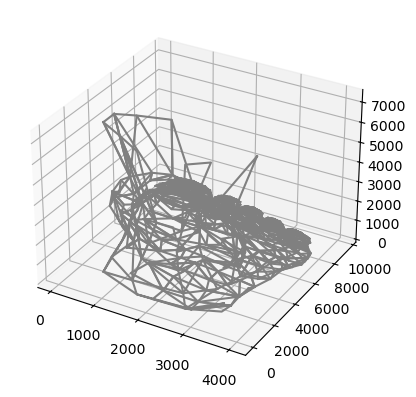

In [181]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for row in faces_final_sample:
    X, Y, Z = get_vertex_coords(row)
    ax.plot(X,Y,Z, color='grey')

Suprisingly, even at 800 faces we are able to see the finer details of our mesh. We sample ~250 to show an example of the triangles .

In [183]:
faces_final_sample = faces_final.sample(250)
faces_final_sample = faces_final_sample['index_coord']

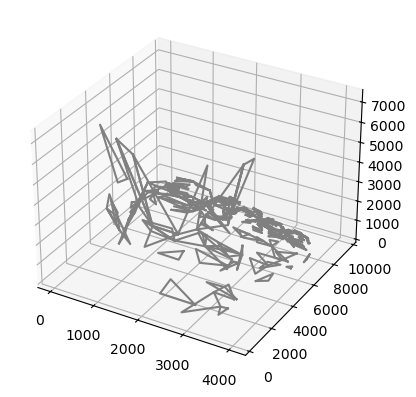

In [184]:
fig_2 = plt.figure()
ax_2 = fig_2.add_subplot(projection='3d')

for row in faces_final_sample:
    X, Y, Z = get_vertex_coords(row)
    ax_2.plot(X,Y,Z, color='grey')

This looks good. Let's proceed with some ML on our meshes.